### Baseline

threshold on the dnbr? 

In [1]:
import rasterio as rio
from rasterio.fill import fillnodata
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import inpaint
from scipy import ndimage


In [52]:
in_file = 'KENNETH_20250109_post_fire.tif'
out_file = 'KENNETH_20250109_interpolated.tif'

In [53]:
with rio.open(in_file) as img:
    data = img.read().astype(np.float32)
    profile = img.profile
    data[data == img.nodata] = np.nan

filled_data = np.zeros_like(data)

for idx in range(data.shape[0]):
    band = data[idx,:, :].copy()
    mask = np.isnan(band)  # True is nan
    if np.any(mask):
        # Replace nan with nearest non-nan values
        indices = ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
        band = band[tuple(indices)]
    filled_data[idx] = band 

profile.update(dtype=rio.float32, nodata=np.nan)

with rio.open(out_file, 'w', **profile) as out:
    out.write(filled_data)

SENTINEL-2 data are acquired on 13 spectral bands in the visible and near-infrared (VNIR) and Short-wavelength infrared (SWIR) spectrum, as show in the below table:

| Band name | Resolution (m) | Central wavelength (nm) | Band width (nm) | Purpose |
|-----------|----------------|-------------------------|-----------------|---------|
|B02|10|490|65|Blue|
|B03|10|560|35|Green|
|B04|10|665|30|Red|
|B08|10|842|115|Near infrared|
|B12|20|2190|180|Snow / ice / cloud discrimination|


Bands in the Tiff data are 'B2', 'B3', 'B4', 'B8', 'B12'

#### Band normlization

https://github.com/allenai/satlas/blob/main/Normalization.md

In [6]:
data.shape
filled_data.shape

(5, 206, 239)

In [7]:
np.isnan(filled_data)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [54]:
with rio.open(out_file) as f:
    bands = f.read()
    norm_data = np.zeros_like(bands)
    for i in range(bands.shape[0]):
        print(f"Max in origin band {i}: {np.max(bands[i])}, Min in origin band {i}: {np.min(bands[i])}")
        # Perform per-band normalization
        norm_data[i] = (bands[i] - np.min(bands[i])) / (np.max(bands[i]) - np.min(bands[i]))
        print(f"Max in normalized band {i}: {np.max(norm_data[i])}, Min in normalized band {i}: {np.min(norm_data[i])}")


Max in origin band 0: 5585.5, Min in origin band 0: 37.0
Max in normalized band 0: 1.0, Min in normalized band 0: 0.0
Max in origin band 1: 5651.5, Min in origin band 1: 69.5
Max in normalized band 1: 1.0, Min in normalized band 1: 0.0
Max in origin band 2: 5692.0, Min in origin band 2: 95.0
Max in normalized band 2: 1.0, Min in normalized band 2: 0.0
Max in origin band 3: 6306.0, Min in origin band 3: 548.5
Max in normalized band 3: 1.0, Min in normalized band 3: 0.0
Max in origin band 4: 4963.0, Min in origin band 4: 497.5
Max in normalized band 4: 1.0, Min in normalized band 4: 0.0


In [55]:
mask_file = r"KENNETH_20250109_mask.tif"

In [56]:
with rio.open(mask_file) as m:
    mask = m.read()

In [57]:
mask.squeeze().shape

(225, 239)

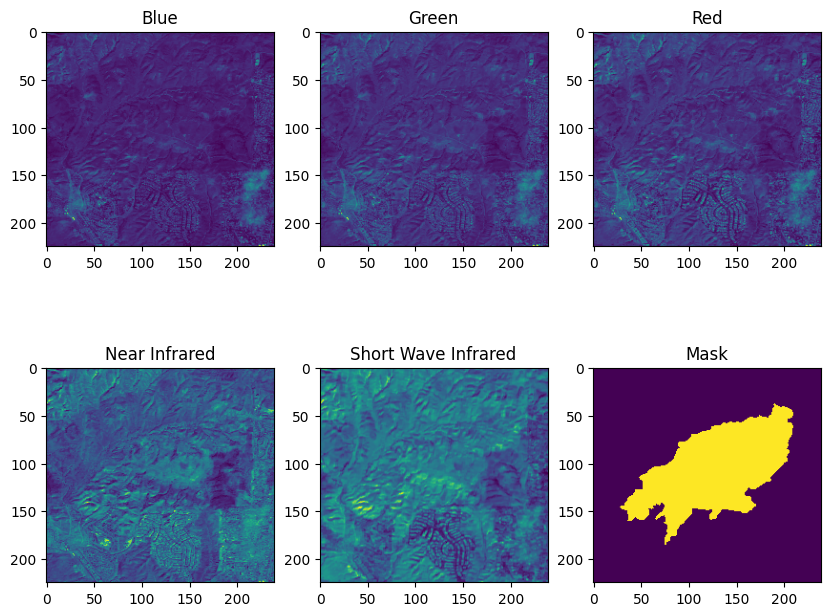

In [58]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax[0, 0].imshow(norm_data[0], )
ax[0, 0].set_title("Blue")
ax[0, 1].imshow(norm_data[1])
ax[0, 1].set_title("Green")
ax[0, 2].imshow(norm_data[2])
ax[0, 2].set_title("Red")
ax[1, 0].imshow(norm_data[3])
ax[1, 0].set_title("Near Infrared")
ax[1, 1].imshow(norm_data[4])
ax[1, 1].set_title("Short Wave Infrared")
ax[1, 2].imshow(mask[0])
ax[1, 2].set_title("Mask")    # 0 is the background
plt.show()

In [112]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import random
import satlaspretrain_models
import matplotlib.pyplot as plt
import rasterio as rio

import torch.optim as optim
import torch.nn.functional as F

#### Process dataset

In [113]:
img_dir = r'data/post_fire'
mask_dir = r'data/masks'
dnbr_dire = r'data/dnbr'

In [114]:
def split_dataset(img_dir, train_ratio = 0.8, val_ratio = 0.1, test_ratio = 0.1, seed = 42):
    data = os.listdir(img_dir)
    data_size = len(data)

    train_size = int(data_size * train_ratio)
    val_size = int(data_size * val_ratio)
    test_size = int(data_size * test_ratio)
    print(f"Training data size {train_size}, Validation data size {val_size}, Testing data size {test_size}")
    
    # Shuffle all images and split into three subsets
    random.seed(seed)
    random.shuffle(data)
    train_data = data[:train_size]
    val_data = data[train_size : train_size+val_size]
    test_data = data[train_size+val_size : data_size]

    return train_data, val_data, test_data

In [115]:
train_data, val_data, test_data = split_dataset(img_dir=img_dir)

Training data size 4, Validation data size 0, Testing data size 0


In [116]:
class FireDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_list, transforms):
        super().__init__()
        self.img_dir = img_dir
        self.mask_dir = mask_dir   # 0, 1 unburned or burned
        self.img_list = img_list
        self.transforms = transforms
    
    def __len__(self):
        return len(self.img_list)

    def fillnan(self, data):
        filled_data = np.zeros_like(data)

        for idx in range(data.shape[0]):
            band = data[idx,:, :].copy()
            mask = np.isnan(band)  # True is nan
            if np.any(mask):
                # Replace nan with nearest non-nan values
                indices = ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
                band = band[tuple(indices)]
            
            band = (band - np.min(band)) / (np.max(band) - np.min(band))
            filled_data[idx] = band

        return filled_data

    def __getitem__(self, idx):
        file_name = self.img_list[idx]

        img_path = os.path.join(self.img_dir, file_name)
        mask_path = os.path.join(self.mask_dir, file_name)

        with rio.open(img_path) as img:
            img_data = img.read().astype(np.float32)
            profile = img.profile
            img_data[img_data == img.nodata] = np.nan
            img_data = self.fillnan(img_data)
        with rio.open(mask_path) as mask:
            mask_data = mask.read()
        
        img_tensor = self.mapping(img_data)
        mask_tensor = torch.from_numpy(mask_data).long().squeeze()

        if self.transforms:
            img_tensor = self.transforms(img_tensor)
            mask_tensor = self.transforms(mask_tensor)
            
        return img_tensor, mask_tensor
    
    def mapping(self, data):
        # Prepare image tensor with shape (9, H, W) for Satlas multi-band model
        # Satlas (multi-band) expects [TCI_R, TCI_G, TCI_B, B05, B06, B07, B08, B11, B12]
        # Band order that I saved: ['B2', 'B3', 'B4', 'B8', 'B12']
        H, W = data.shape[1], data.shape[2]
        out = np.zeros((9, H, W), dtype=np.float32)
        
        B2, B3, B4, B8, B12 = data
        out[0] = B4  # Red
        out[1] = B3  # Green
        out[2] = B2  # Blue
        out[6] = B8  # NIR
        out[8] = B12 # SWIR

        return torch.from_numpy(out).float()

In [89]:
## Create dataloader
transform_train = transforms.Compose([
            transforms.RandomCrop(224, padding=4),
            transforms.RandomVerticalFlip()
            ])

train_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=train_data, transforms=transform_train)
val_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=val_data, transforms=None)
test_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=test_data, transforms=None)

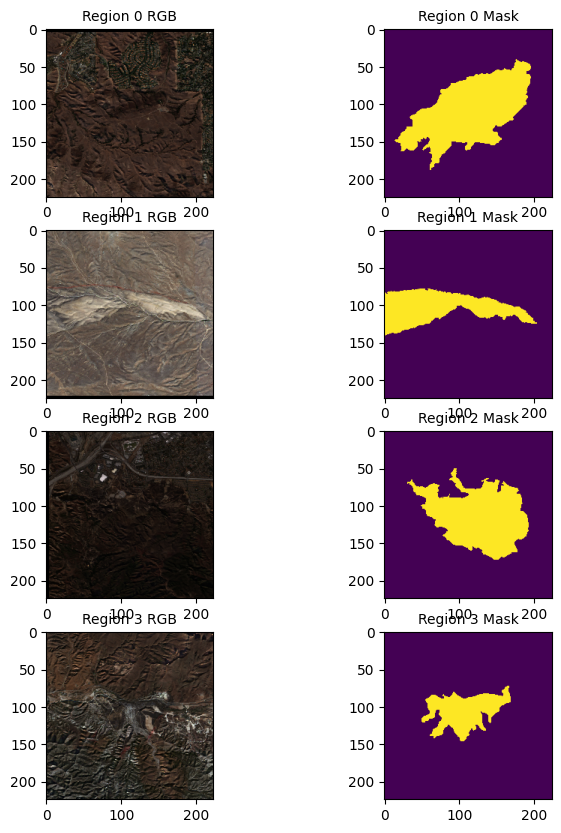

In [97]:
# Visualize few samples
fig, ax = plt.subplots(4, 2, figsize=(8, 10))
for i in range(4):
    data, target = train_dataset[i]

    image = data.numpy()
    target = target.numpy()
    
    rgb = image[:3]
    rgb = np.rollaxis(rgb, 0, rgb.ndim)
    ax[i, 0].imshow(rgb)
    ax[i, 0].set_title(f"Region {i} RGB", fontsize=10)
    ax[i, 1].imshow(target)
    ax[i, 1].set_title(f"Region {i} Mask", fontsize=10)

plt.show()

In [79]:
batch_size = 16
num_workers = 4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#### Load a pre-trained model from remote sensing foundation models
https://pypi.org/project/satlaspretrain-models/

https://github.com/allenai/satlaspretrain_models/blob/main/demo.ipynb

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize a Weights instance to specify the pretrained model
weights_manager = satlaspretrain_models.Weights()

# The pretrained model that I used here is from remote sensing foundation models, which is pretrained on Sentinel-2 
# Choose segmentation head for binary classes
# Load backbone + FPN
model = weights_manager.get_pretrained_model(model_identifier="Sentinel2_SwinB_SI_MS", 
                                             fpn=True,
                                             num_categories=2,
                                             head=satlaspretrain_models.Head.SEGMENT,
                                             device=device)


In [ ]:
# Check the model architecture
# https://github.com/allenai/satlas/blob/main/ModelArchitecture.md
# model

for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

#### Setup training process



source: https://blog.paperspace.com/image-segmentation-using-segmentation_models_pytorch/

In [ ]:
lr = 1e-4
epochs = 10

optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
# https://medium.com/data-scientists-diary/implementation-of-dice-loss-vision-pytorch-7eef1e438f68

def dice_loss(outputs, targets):
    num_classes=outputs.shape[1]
    # One-hot encoding with tensor shape (N, C, H, W)
    targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float().to(targets.device)
    probs = F.softmax(outputs, dim=1)  # Compute prob across number of classes
    
    dims = (0, 2, 3)
    epsilon = 1e-6
    # Compute dice for fire area and background
    intersection = torch.sum(probs * targets_one_hot, dim=dims)
    cardinality = torch.sum(probs + targets_one_hot, dim=dims)
    union = cardinality - intersection
    dice_per_class = (2. * intersection + epsilon) / (cardinality + epsilon)
    iou_per_class = (intersection + epsilon) / (union + epsilon) 

    # Handle imbalanced classes
    class_counts = torch.sum(targets_one_hot, dim=dims)
    class_weights = 1.0 / (class_counts + epsilon)
    class_weights = class_weights / class_weights.sum()
    weights = torch.tensor(class_weights, device=targets.device)

    # Weighted dice
    weighted_dice = torch.sum(dice_per_class * weights)
    weighted_iou = torch.sum(iou_per_class * weights) / weights.sum()

    # return dice loss
    return 1.0 - weighted_dice, weighted_dice, weighted_iou

In [ ]:
def train(model, train_dataloader, optimizer, criterion, device='cpu'):
    model.train()
    sum_loss = 0

    for batch_idx, (input, target) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss, _, _ = criterion(outputs, targets)
        loss.backward()
        sum_loss += loss.item() * input.size(0)
        optimizer.step()

    average_loss = sum_loss / len(train_dataloader)
    return average_loss

In [108]:
def validate(model, val_dataloader, criterion, device='cpu'):
    model.eval()
    sum_loss = 0
    sum_dice = 0
    sum_iou = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss, dice_score, iou = criterion(outputs, targets)
            sum_loss += loss.item() * inputs.size(0)
            sum_dice += dice_score.item() * inputs.size(0)
            sum_iou += iou.item() * inputs.size(0)

    average_loss = sum_loss / len(val_dataloader)
    average_dice = sum_dice / len(val_dataloader)
    average_iou = sum_iou / len(val_dataloader)
    return average_loss, average_dice, average_iou


In [110]:
def run(model, epochs, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device='cpu'):
    for epoch in range(1, epochs + 1):
        scheduler.step(epoch)
        train_loss = train(model, 
                           train_dataloader=train_dataloader, 
                           optimizer=optimizer, 
                           criterion=criterion,
                           device=device,)
        val_loss, val_dice, val_iou = validate(model, 
                            val_dataloader=val_dataloader,
                            criterion=criterion,
                            device=device,)
        print(f"Epoch {epoch}: train loss {train_loss} | val loss {val_loss} | val dice {val_dice} | val iou {val_iou}")

In [111]:
run(model, 5, train_dataloader, val_dataloader, optimizer, dice_loss, scheduler)

d:\conda\anaconda3\envs\3dcv\lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
d:\conda\anaconda3\envs\3dcv\lib\site-packages\torch\optim\lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.wa

PicklingError: Can't pickle <class '__main__.FireDataset'>: it's not the same object as __main__.FireDataset